In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

In [27]:
class BernoulliBandit:
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K
    
    def step(self, k):
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

np.random.seed(1)
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号，其获奖概率为%.4f" % 
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号，其获奖概率为0.7203


In [28]:
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)
        self.regret = 0.
        self.actions = []
        self.regrets = []
    
    def update_regret(self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)
    
    def run_one_step(self):
        raise NotImplementedError
    
    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

### $\epsilon$-贪心算法

在常规的贪心算法中添加噪声，这样前期可以选择到当前非最大期望的动作A用于探索。$\epsilon $随着时间（步数）减小，在后期更倾向于选择期望最大的动作。
$$
a_t = 
\begin{cases} 
\arg\max_{a \in A} \hat{Q}(a), & \text{采样概率：} 1-\epsilon \\
\text{从 } A \text{ 中随机选择}, & \text{采样概率：} \epsilon 
\end{cases}
$$

In [29]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super().__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K)
    
    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K) # 随机选一根拉杆
        else:
            k = np.argmax(self.estimates) # 选择期望估值最大的拉杆

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

epsilon-贪婪算法的累计懊悔为：26.372011729333263


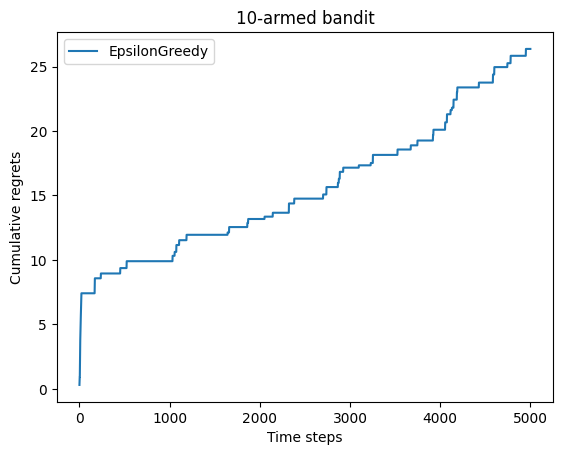

In [33]:
def plot_results(solvers, solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title(f'{solvers[0].bandit.K}-armed bandit')
    plt.legend()
    plt.show()

epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print(f'epsilon-贪婪算法的累计懊悔为：{epsilon_greedy_solver.regret}')
plot_results([epsilon_greedy_solver], ['EpsilonGreedy'])

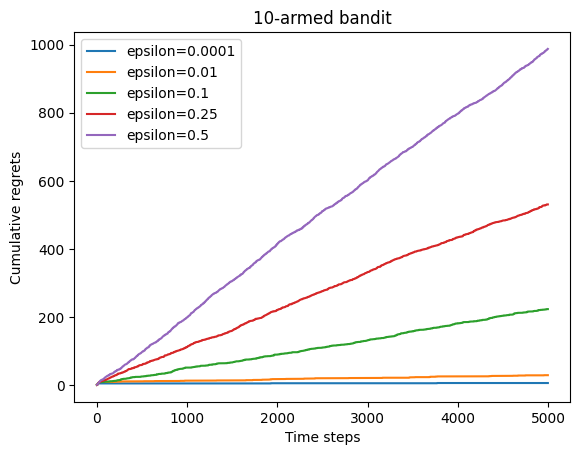

In [34]:
from matplotlib.pyplot import plot


np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

#### 加入时间衰减

epsilon值衰减的贪婪算法的累计懊悔为：8.404392658155848


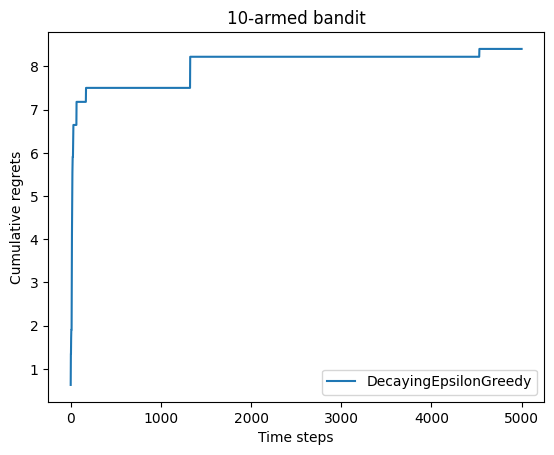

In [44]:
class DecayingEpsilonGreedy(Solver):
    def __init__(self, bandit, init_prob=1.0):
        super().__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0
    
    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:
            k = np.random.randint(0, self.bandit.K) # 随机选一根拉杆
        else:
            k = np.argmax(self.estimates) # 选择期望估值最大的拉杆

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k
    
epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
epsilon_greedy_solver.run(5000)
print(f'epsilon值衰减的贪婪算法的累计懊悔为：{epsilon_greedy_solver.regret}')
plot_results([epsilon_greedy_solver], ['DecayingEpsilonGreedy'])

### 上置信界算法

根据霍夫丁不等式（Hoeffding's inequality）：
$$
\mathbb{P}\left(\mathbb{E}[X] \geq \bar{x}_n + u\right) \leq e^{-2nu^2}
$$
对于任意一个独立随机变量的分布，通过探索得到了 $n$ 个样本值 $X_1, X_2, \ldots, X_n$，样本均值和实际期望之间的差值大于$u$的概率不会超过 $ e^{-2nu^2} $。

所以设定一个置信度的阈值，例如 $0.95$ ，此时可以得到一个确定的 $u$ 值，即我们知道了期望在指定置信度下的最大值（$\bar{x}_n + u$），即上界。

在探索初期，探索次数更少、不确定度较大的选项，独立分布的期望上界更大，更可能被选择。随着探索次数变多，期望上界范围会更小，更接近期望值，此时真正期望更大的选项就会更容易被选择。

令置信度 $p = \frac{1}{t}$，则 $\hat{U}_t = \sqrt{\frac{\log t}{2(N_t+1)}}$，此时数据的均值为 $\hat{Q}_t$

则置信上界可表示为：
$$
\hat{Q}_t + \cdot \hat{U}_t
$$

为 $\hat{U}_t$ 加上系数 $c$ 以控制不确定度的影响。

此时，我们每步要选择的动作 $a$ 为：
$$a = \arg\max_{a \in A} \hat{Q}_t(a) + c \cdot \hat{U}_t(a)$$

上置信界算法的累计懊悔为：64.88243507364709


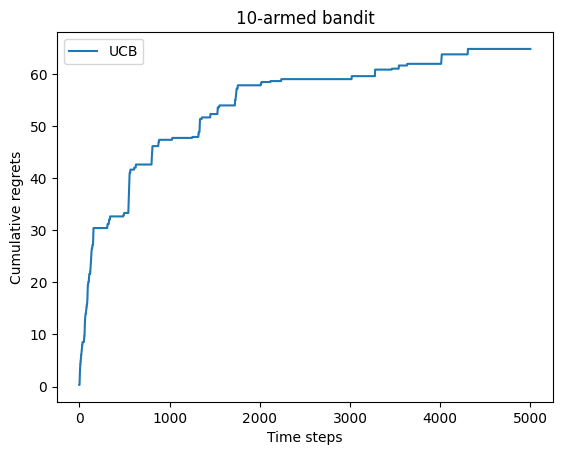

In [67]:
class UCB(Solver):
    def __init__(self, bandit, coef, init_prob=1.0):
        super().__init__(bandit)
        self.total_count = 0
        self.coef = coef
        self.estimates = np.array([init_prob] * self.bandit.K)
    
    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k
    
coef = 1
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print(f'上置信界算法的累计懊悔为：{UCB_solver.regret}')
plot_results([UCB_solver], ['UCB'])

### 汤普森采样算法

汤普森采样算法假设拉动每根拉杆的奖励服从一个特定的概率分布。这里我们使用Beta分布对当前每个动作的奖励概率分布进行建模。
Beta 分布 $Beta(\alpha, \beta)$ 的概率密度函数（PDF）由下式给出：
$$
f(x; \alpha, \beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}
$$

$\alpha, \beta$ 是决定分布情况的参数，可以理解为是分布向正或负样本的偏向。

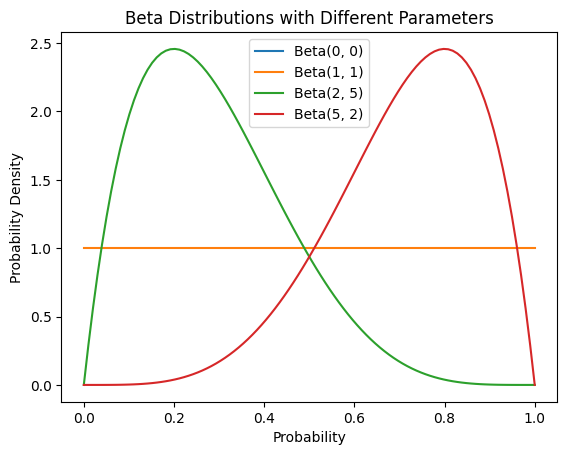

In [142]:
def plot_beta_distributions(params):
    x = np.linspace(0, 1, 100)
    for alpha_param, beta_param in params:
        y = beta.pdf(x, alpha_param, beta_param)
        plt.plot(x, y, label=f'Beta({alpha_param}, {beta_param})')
    plt.legend()
    plt.title('Beta Distributions with Different Parameters')
    plt.xlabel('Probability')
    plt.ylabel('Probability Density')
    plt.show()

params = [(0, 0), (1, 1), (2, 5), (5, 2)]
plot_beta_distributions(params)

由于 Beta 分布是共轭先验的，若某拉杆被选择了 $k$ 次，其中 $m_1$ 次奖励为 1，$m_2$ 次奖励为 0，则该拉杆的奖励服从参数为 $(m_1 + 1, m_2 + 1)$ 的 Beta 分布。

汤普森采样算法的累计懊悔为：57.19161964443925


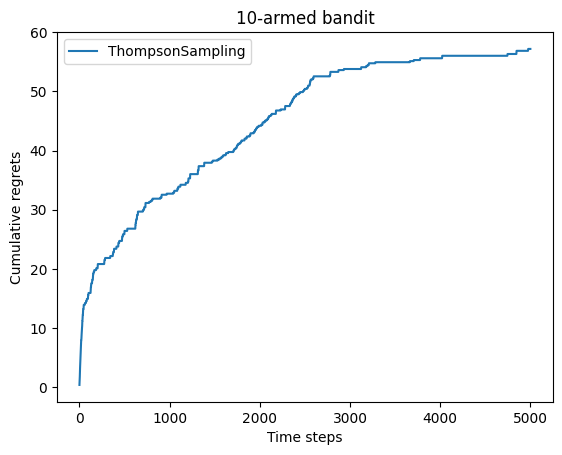

In [246]:
class ThompsonSampling(Solver):
    def __init__(self, bandit):
        super().__init__(bandit)
        self._a = np.ones(self.bandit.K) # 每个拉杆的奖励为1的次数
        self._b = np.ones(self.bandit.K) # 每个拉杆的奖励为0的次数
    
    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)
        k = np.argmax(samples)
        r = self.bandit.step(k)

        self._a[k] += r
        self._b[k] += (1 - r)
        return k

np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000) 
print(f'汤普森采样算法的累计懊悔为：{thompson_sampling_solver.regret}')
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

#### 贝叶斯推理

$$ P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta)}{\int P(X \mid \theta) P(\theta) \, d\theta} $$
这里：
- $ P(\theta \mid X) $ 是后验概率，表示在给定数据 $ X $ 的情况下参数 $ \theta $ 的概率。
- $ P(X \mid \theta) $ 是似然函数，表示在给定参数 $ \theta $ 的情况下观察到数据 $ X $ 的概率。
- $ P(\theta) $ 是先验概率，表示在观察到数据 $ X $ 之前参数 $ \theta $ 的概率。
- $ \int P(X \mid \theta) P(\theta) \, d\theta $ 是边缘似然，表示观察到数据 $ X $ 的总概率，通过对所有可能的 $ \theta $ 值进行积分来计算。

贝叶斯定理允许我们根据新的证据（数据）更新我们对某个假设（参数）的信念（概率）。这是贝叶斯统计和贝叶斯推理的基础。


用一个具体的例子来理解贝叶斯定理：

有一个小朋友叫叶子黄，她每天中午的午饭可能是木桶饭或者袁记云饺。我们需要计算她午饭选择的概率分布。

##### 先验分布 $P(\theta)$

根据我们的观察，她在学校的时候特别喜欢吃老上海馄饨，所以可以推测她吃袁记云饺的可能性更高。

现在，我们需要根据已有的知识构建一个先验分布，表示午饭选择的可能的概率分布。我们将吃袁记云饺的概率定义为 $\theta$，则吃木桶饭的概率为 $1- \theta$，我们只要得到   $\theta$ 的概率分布 $P(\theta)$ 就可以对整个午饭选择进行建模。

首先，吃木桶饭或者袁记云饺，这是一个二项分布，为了表示 $P(\theta)$，该域的范围应该在(0, 1)，并且是连续分布的。所以我们在这里选择Beta分布作为先验分布，用 $\alpha, \beta$ 可以表示吃袁记云饺和木桶饭的比例。

这里我们假设叶子黄吃袁记云饺的概率是70%，她一个月吃21次袁记，9次木桶饭。于是，我们的先验分布可以是 $B(21, 9)$ 。
问题出现了，既然是表示比例，先验分布能不能是 $B(7, 3), B(28, 12), 甚至B(2100, 900)$？

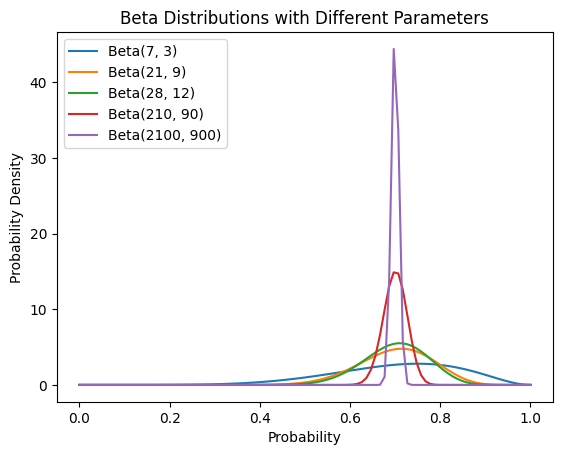

In [144]:
params=[(7, 3), (21, 9), (28, 12), (210, 90), (2100, 900)]
plot_beta_distributions(params)

观察这几个分布图可以看到，$\alpha, \beta$ 的数值越大，概率的范围就越小，概率密度就越大，这代表了我们对这个先验分布的“信念”，或者说自信程度。

如果我们选择的分布是 $B(2100, 900)$，说明我们非常自信叶子黄更爱吃袁记云饺，后续除非有大量的数据说明她爱吃木桶饭，不然这个信念很难被撼动。

但是我们现在还没有拿到任何的真实数据，所以我们得选一比较小的参数值，一个比较弱的信念，这里选择 $B(7, 3)$ 作为我们的先验分布。

##### 似然分布  $P(X | \theta)$


似然分布其实就是在给定参数 $\theta$ 的情况下，看到数据 $X$ 的概率。

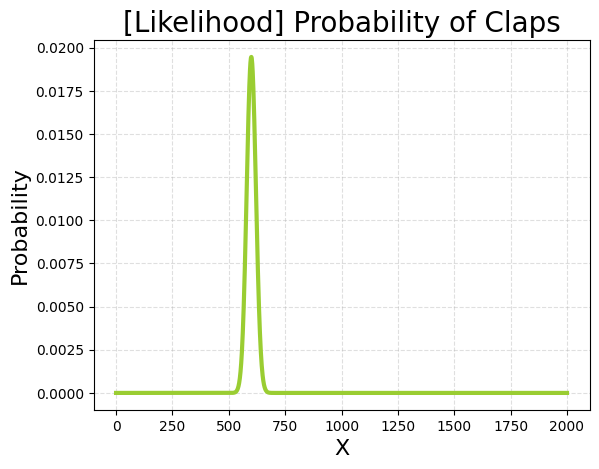

In [145]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# 假设点赞概率 theta
clap_prob = 0.3
clap_data = np.random.binomial(n=1, p=clap_prob, size=2000)

# X的所有可能取值（点赞次数）
X = np.arange(0, len(clap_data)+1)

# 计算每个X对应的似然概率
likelihood = stats.binom.pmf(k=X, n=len(clap_data), p=clap_prob)

# 绘制似然分布曲线
fig, ax = plt.subplots()
plt.plot(X, likelihood, linewidth=3, color='yellowgreen')
plt.title('[Likelihood] Probability of Claps', fontsize=20)
plt.xlabel('X', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.grid(alpha=.4, linestyle='--')
plt.show()

在选择似然分布 $P(X|\theta)$ 时，我们需要根据数据的类型来决定概率模型。

我们的数据 $X$ 是一个二元数组，例如：[0, 1, 0, 1, ..., 0, 0, 0, 1]，每个元素表示一次试验的结果（吃袁记还是木桶饭）。我们还知道总试验次数 $N$ 和点赞次数 $X$，以及点赞的概率 $P$。

这正是二项分布的典型场景：在 $n$ 次试验中，每次成功的概率为 $p$，我们关心 $X$ 次成功的概率。

因此，采样分布（似然分布）可以用二项分布来建模：
$$
P(X|\theta) = \binom{n}{X} \theta^X (1-\theta)^{n-X}
$$
其中 $\theta$ 即为选择吃袁记的概率（如 $\theta=0.3$），$n$ 为总试验次数，$X$ 为成功次数。

需要注意的是，似然分布不是可以选择的，并非我们选择用二项分布来建模，而是由于我们设定的场景，数据本身必然符合二项分布。在大多数的实际应用场景中，似然分布是难以用简单的函数来描述的。

##### 后验分布 $P(\theta | X)$


后验分布就是在得到一批X数据后，再推断 $\theta$ 的分布。这个推断就是根据贝叶斯公式计算的。或许可以这样理解：
![贝叶斯推理示意图](./imgs/贝叶斯推理.png)

将似然分布作用在先验分布上，得到后验分布，类似于梯度下降中，使用梯度更新权重。更新后得到的后验分布，可以用于下一次迭代的先验分布，如此不断更新知道找到最准确的分布。

由于木桶饭过于好吃，叶子黄现在每天中午都固定吃木桶饭，与先验分布偏差很大，我们收集了她最近30天的午饭数据，发现她吃了27次木桶饭，3次袁记云饺。

在经过一轮更新后，我们可以得到后验分布 $P(\theta | X)$，即吃袁记云饺的概率 $\theta$ 的分布。

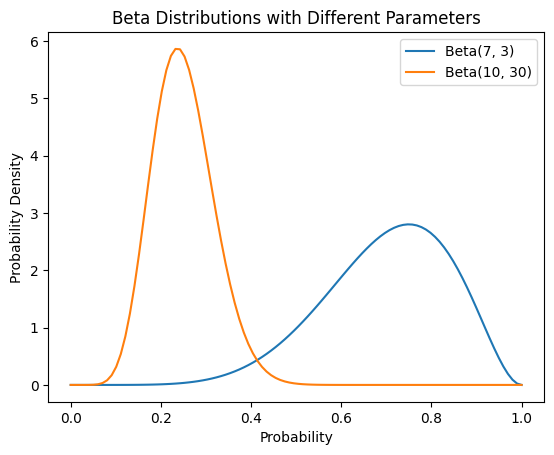

In [ ]:
plot_beta_distributions([(7, 3), (10, 30)]) # 使用了共轭先验的Beta分布，后面会讲

接下来我们尝试更改参数来观察这个后验分布的推断过程。

In [203]:
def plot_bayes_evolution_grid(param_list):
    import math
    n = len(param_list)
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axes = axes.flatten()
    # 先收集所有分布的最大值
    y_max = 0
    all_distributions = []
    for params in param_list:
        alpha, beta_param, n_tosses, theta_true = params
        x = np.linspace(0, 1, 200)
        heads, tails = 0, 0
        prior = x**(alpha-1) * (1-x)**(beta_param-1)
        prior /= prior.sum()
        all_distributions.append(prior)
        y_max = max(y_max, prior.max())
        posterior = prior.copy()
        for i in range(n_tosses):
            result = np.random.rand()
            if result < theta_true:
                heads += 1
            else:
                tails += 1
            likelihood = x**heads * (1-x)**tails
            posterior = prior * likelihood
            posterior /= posterior.sum()
            all_distributions.append(posterior)
            y_max = max(y_max, posterior.max())
            prior = posterior
    # 重新绘制
    for idx, params in enumerate(param_list):
        alpha, beta_param, n_tosses, theta_true = params
        x = np.linspace(0, 1, 200)
        heads, tails = 0, 0
        prior = x**(alpha-1) * (1-x)**(beta_param-1)
        prior /= prior.sum()
        axes[idx].plot(x, prior, label=f'Prior Beta({alpha},{beta_param})', color='lightblue')
        posterior = prior.copy()
        for i in range(n_tosses):
            result = np.random.rand()
            if result < theta_true:
                heads += 1
            else:
                tails += 1
            likelihood = x**heads * (1-x)**tails
            posterior = prior * likelihood
            posterior /= posterior.sum()
            axes[idx].plot(x, posterior, color=plt.cm.Blues(0.3 + 0.7*i/n_tosses))
            prior = posterior
        axes[idx].axvline(theta_true, color='red', linestyle='--', linewidth=2, label=f'true θ={theta_true}')
        axes[idx].set_title(f'α={alpha}, β={beta_param}, tosses={n_tosses}, θ={theta_true}')
        axes[idx].set_xlabel('Probability')
        axes[idx].set_ylabel('Density')
        axes[idx].legend()
        axes[idx].set_ylim(0, y_max * 1.05)  # 统一y轴
    for i in range(n, nrows * ncols):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

设定不同的真实 $\theta$，可以看到随着数据增加，分布在逐渐偏向真实分布

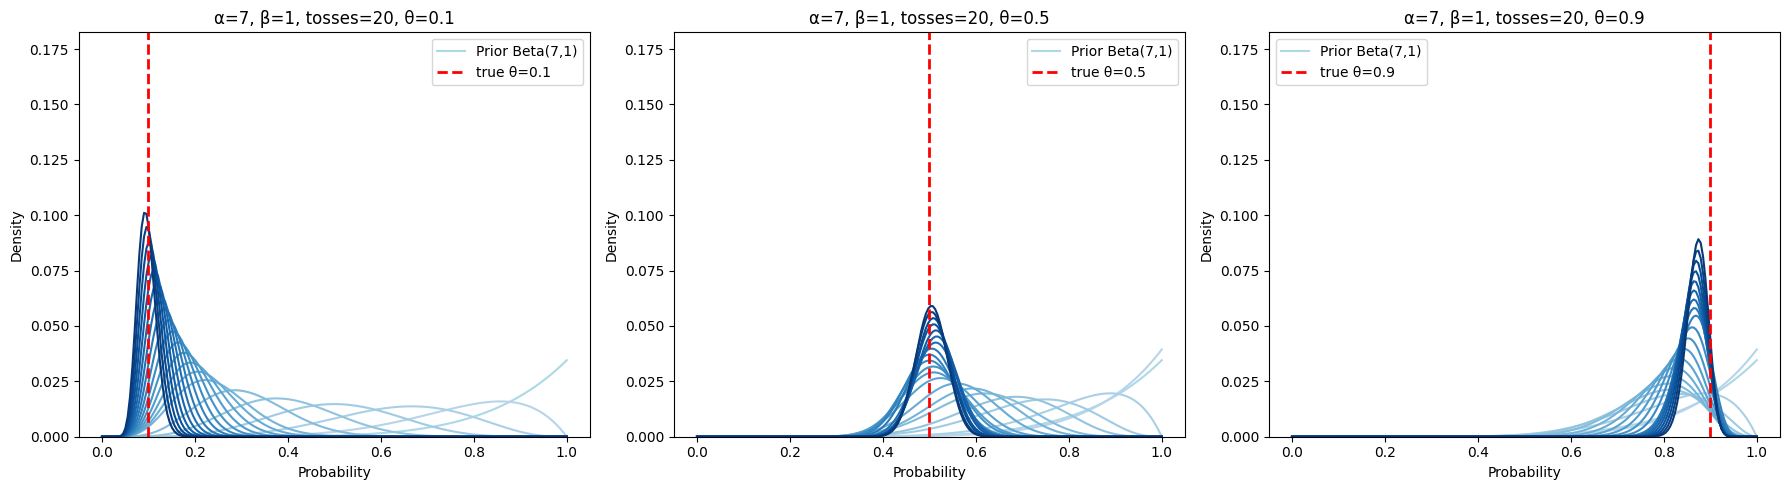

In [218]:
plot_bayes_evolution_grid([
    (7, 1, 20, 0.1),
    (7, 1, 20, 0.5),
    (7, 1, 20, 0.9)])

增大先验分布的 $\alpha, \beta$ 可以看到在有限步数内，后验分布更难更新至真实分布

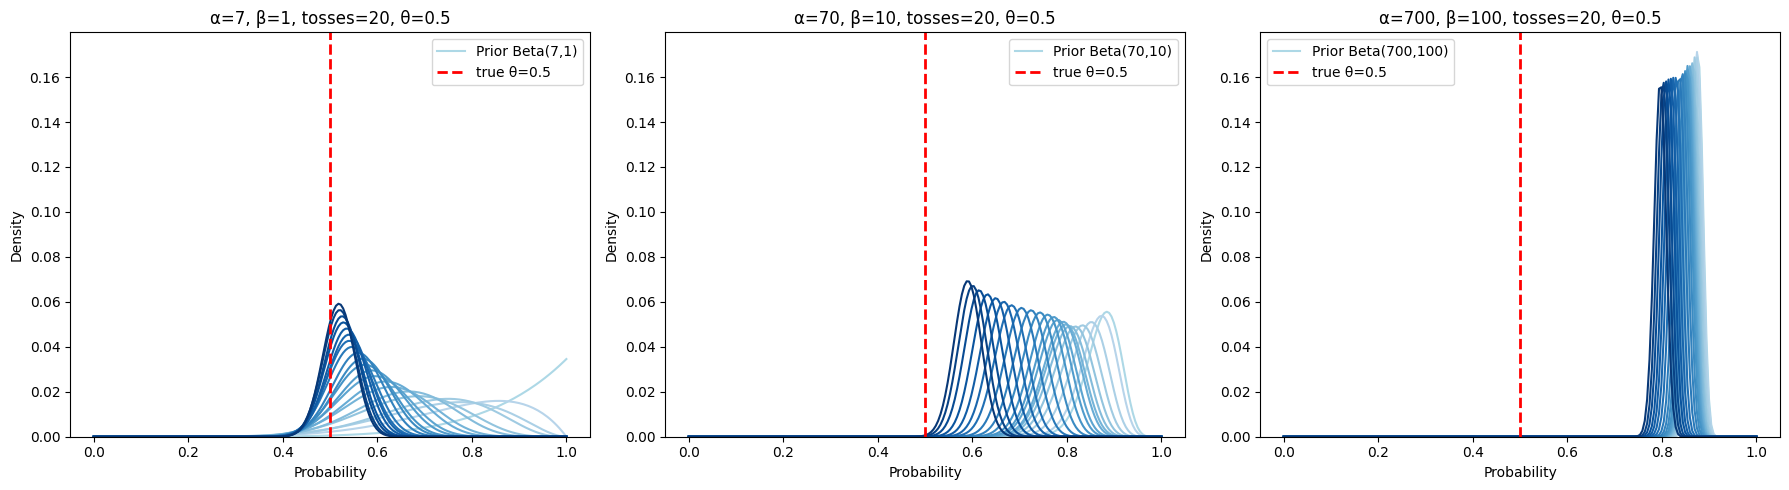

In [233]:
plot_bayes_evolution_grid([
    (7, 1, 20, 0.5),
    (70, 10, 20, 0.5),
    (700, 100, 20, 0.5)])

##### 共轭先验

共轭先验是贝叶斯推断中的一个重要概念。
当我们选择某种先验分布 $P(\theta)$，如果在与某种似然分布 $P(X|\theta)$ 结合后，得到的后验分布 $P(\theta|X)$ 仍然属于同一分布族，那么这种先验分布就称为该似然分布的“共轭先验”。
例如：
- 对于二项分布或伯努利分布的似然函数，Beta分布就是它的共轭先验。
- 对于正态分布的似然函数，正态分布本身也是共轭先验。

**优点**：
- 计算后验分布时非常方便，通常有封闭式公式，无需复杂积分或数值计算。
- 可以直接更新参数，便于迭代推断。

**以Beta分布为例**：
假设先验为 $Beta(\alpha, \beta)$，观测到 $X$ 次成功，$N-X$ 次失败，则后验分布为：
$$
P(\theta|X) \propto \theta^{\alpha+X-1}(1-\theta)^{\beta+N-X-1}
$$
即后验分布仍然是Beta分布，只是参数变成 $(\alpha+X, \beta+N-X)$。

**直观理解**：
- 共轭先验让我们可以像“加法”一样更新参数，把新数据直接加到先验参数上。
- 这样每次有新数据，分布就能快速更新，无需重新积分。